In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

#from sequence_logo_helper import plot_dna_logo

import pandas as pd
'''
from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()
'''
class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

from scipy.stats import pearsonr, spearmanr


Using TensorFlow backend.


In [2]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


In [3]:
#Load data features

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")

#Include cell types

included_cell_types = [
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
]

x, m, l, c, y, s = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

#Add extra singleton dim to x
x = np.expand_dims(x, axis=2)

#Shuffle c and y dimensions
c = np.transpose(c, (0, 2, 1))
y = np.transpose(y, (0, 2, 1))

#Slice celltypes

included_cell_type_ixs = [cell_type_dict[cell_type] for cell_type in included_cell_types]

cell_types = cell_types[included_cell_type_ixs]
c = c[:, included_cell_type_ixs, :]
y = y[:, included_cell_type_ixs, :]
s = s[:, included_cell_type_ixs]

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (5267, 10, 1, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 27, 10)
y.shape = (5267, 27, 10)
s.shape = (5267, 27)


In [4]:
#Collapse/omit PASes that are to close in spatial distance

collapse_if_within = 50.
omit_if_within = 100.

for i in range(x.shape[0]) :
    
    curr_pas = 0
    next_pas = 1
    
    while next_pas < x.shape[1] :
        
        if m[i, next_pas] <= 0. :
            break
        
        if l[i, next_pas] <= collapse_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            
            c[i, :, curr_pas] += c[i, :, next_pas]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        elif l[i, next_pas] <= omit_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        else :
            curr_pas += 1
        
        next_pas += 1


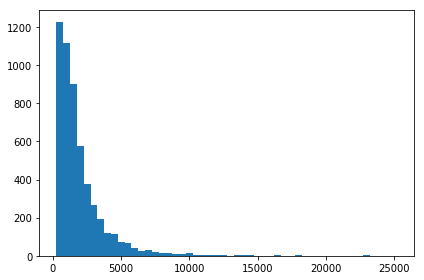

In [5]:

f = plt.figure(figsize=(6, 4))

plt.hist(np.minimum(np.max(l, axis=1), 120000.), bins=50)

plt.tight_layout()

plt.show()


In [6]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 0.

x = x[:, :max_n_pas, ...]
m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

x = x[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), ...]
m = m[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), :]
l = l[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), :]
c = c[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), ...]

y = c / np.sum(c, axis=2, keepdims=True)
y[np.isnan(y)] = 0.

s = np.array(np.sum(c, axis=2) > 0, dtype=np.float)

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (5146, 10, 1, 205, 4)
m.shape = (5146, 10)
l.shape = (5146, 10)
c.shape = (5146, 27, 10)
y.shape = (5146, 27, 10)
s.shape = (5146, 27)


In [7]:

cell_type_differences = [
    ['NT', cell_type] for cell_type in cell_types[1:].tolist()
]

d = np.zeros((x.shape[0], s.shape[1], s.shape[1]))

for [cell_type_1, cell_type_2] in cell_type_differences :
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]
    
    d[:, cell_type_1_ix, cell_type_2_ix] = 1.

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))
print("d.shape = " + str(d.shape))


x.shape = (5146, 10, 1, 205, 4)
m.shape = (5146, 10)
l.shape = (5146, 10)
c.shape = (5146, 27, 10)
y.shape = (5146, 27, 10)
s.shape = (5146, 27)
d.shape = (5146, 27, 27)


In [8]:
#Log-transform feature matrix l

l = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.maximum(l - 5., 0)


In [9]:
#Create proximal and distal masks

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

prox_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    prox_mask[i, prox_index[i]] = 1.

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [10]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent = load_model(model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

isoform_start = 77
isoform_end = 127

a = np.zeros((x.shape[0], x.shape[1]))
for k in range(x.shape[1]) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    onehots = x[:, k, ...]
    
    fake_lib = np.zeros((onehots.shape[0], 13))
    fake_lib[:, 11] = 1.
    
    #Pad
    n_pad = 32 - onehots.shape[0] % 32 if onehots.shape[0] % 32 != 0 else 0

    fake_lib = np.concatenate([fake_lib, np.zeros((n_pad, 13))], axis=0)
    onehots = np.concatenate([onehots, np.zeros((n_pad, 1, 205, 4))], axis=0)
    
    _, pred_cuts = aparent.predict(x=[onehots, fake_lib], batch_size=32, verbose=1)
    
    if n_pad > 0 :
        pred_cuts = pred_cuts[:-n_pad, :]
    
    pred_iso = np.sum(pred_cuts[:, isoform_start:isoform_end], axis=1)
    pred_logit = np.log(pred_iso / (1. - pred_iso))
    
    a[:, k] = pred_logit[:]

a = a * m
a = np.clip(a, -10., 10.)


Predicting for PAS #0...
5152/5152 [==============================] - 8s 1ms/step
Predicting for PAS #1...
5152/5152 [==============================] - 2s 396us/step
Predicting for PAS #2...
5152/5152 [==============================] - 2s 395us/step
Predicting for PAS #3...
5152/5152 [==============================] - 2s 396us/step
Predicting for PAS #4...
5152/5152 [==============================] - 2s 396us/step
Predicting for PAS #5...
5152/5152 [==============================] - 2s 393us/step
Predicting for PAS #6...
5152/5152 [==============================] - 2s 395us/step
Predicting for PAS #7...
5152/5152 [==============================] - 2s 393us/step
Predicting for PAS #8...
5152/5152 [==============================] - 2s 395us/step
Predicting for PAS #9...
5152/5152 [==============================] - 2s 393us/step


In [11]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_scores_all", a)
a = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_scores_all.npy")

print(a.shape)


(5146, 10)


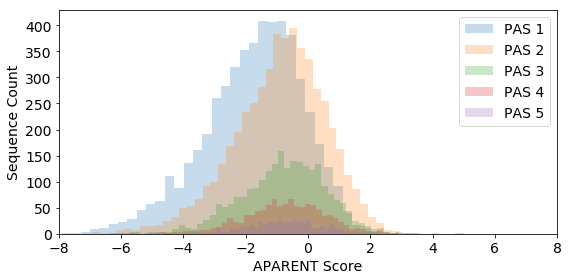

In [12]:
#Plot distribution of APARENT scores per PAS

f = plt.figure(figsize=(8, 4))

plt.hist(a[:, 0][m[:, 0] >= 1.], bins=50, alpha=0.25, label="PAS 1")
plt.hist(a[:, 1][m[:, 1] >= 1.], bins=50, alpha=0.25, label="PAS 2")
plt.hist(a[:, 2][m[:, 2] >= 1.], bins=50, alpha=0.25, label="PAS 3")
plt.hist(a[:, 3][m[:, 3] >= 1.], bins=50, alpha=0.25, label="PAS 4")
plt.hist(a[:, 4][m[:, 4] >= 1.], bins=50, alpha=0.25, label="PAS 5")

plt.legend(fontsize=14)

plt.xlim(-8., 8.)
plt.ylim(0.)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("APARENT Score", fontsize=14)
plt.ylabel("Sequence Count", fontsize=14)

plt.tight_layout()

plt.show()


In [13]:
#Partition data into train, valid, test

n_valid = 500
n_test = 500

x_train = x[:-n_valid - n_test, ...]
m_train = m[:-n_valid - n_test, ...]
prox_mask_train = prox_mask[:-n_valid - n_test, ...]
dist_mask_train = dist_mask[:-n_valid - n_test, ...]
l_train = l[:-n_valid - n_test, ...]
c_train = c[:-n_valid - n_test, ...]
y_train = y[:-n_valid - n_test, ...]
s_train = s[:-n_valid - n_test, ...]
d_train = d[:-n_valid - n_test, ...]
a_train = a[:-n_valid - n_test, ...]

x_valid = x[-n_valid - n_test:-n_test, ...]
m_valid = m[-n_valid - n_test:-n_test, ...]
prox_mask_valid = prox_mask[-n_valid - n_test:-n_test, ...]
dist_mask_valid = dist_mask[-n_valid - n_test:-n_test, ...]
l_valid = l[-n_valid - n_test:-n_test, ...]
c_valid = c[-n_valid - n_test:-n_test, ...]
y_valid = y[-n_valid - n_test:-n_test, ...]
s_valid = s[-n_valid - n_test:-n_test, ...]
d_valid = d[-n_valid - n_test:-n_test, ...]
a_valid = a[-n_valid - n_test:-n_test, ...]

x_test = x[-n_test:, ...]
m_test = m[-n_test:, ...]
prox_mask_test = prox_mask[-n_test:, ...]
dist_mask_test = dist_mask[-n_test:, ...]
l_test = l[-n_test:, ...]
c_test = c[-n_test:, ...]
y_test = y[-n_test:, ...]
s_test = s[-n_test:, ...]
d_test = d[-n_test:, ...]
a_test = a[-n_test:, ...]

print("x_train.shape = " + str(x_train.shape))
print("x_valid.shape = " + str(x_valid.shape))
print("x_test.shape = " + str(x_test.shape))


x_train.shape = (4146, 10, 1, 205, 4)
x_valid.shape = (500, 10, 1, 205, 4)
x_test.shape = (500, 10, 1, 205, 4)


In [14]:
#PAS network definition

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func


In [15]:
#Define model code

def get_kl_divergence(max_n_pas, n_cell_types) :

    def _kl_divergence(y_true, y_pred, pas_mask, cell_type_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        kl = y_true * K.log(y_true / y_pred)
        kl = kl * K.tile(K.expand_dims(cell_type_mask, axis=-1), (1, 1, max_n_pas))
        kl = kl * K.tile(K.expand_dims(pas_mask, axis=1), (1, n_cell_types, 1))
        total_kl = K.sum(kl, axis=-1)

        mean_total_kl = K.mean(total_kl, axis=-1)

        return mean_total_kl

    return _kl_divergence

def get_difference_mse(max_n_pas, n_cell_types) :

    def _difference_mse(y_true, y_pred, pas_mask, cell_type_mask, diff_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        y_true_1 = K.expand_dims(y_true, axis=1)
        y_true_2 = K.expand_dims(y_true, axis=2)
        y_true_diff = y_true_1 - y_true_2

        y_pred_1 = K.expand_dims(y_pred, axis=1)
        y_pred_2 = K.expand_dims(y_pred, axis=2)
        y_pred_diff = y_pred_1 - y_pred_2

        cell_type_mask_1 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=1), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_2 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=2), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_diff = cell_type_mask_1 * cell_type_mask_2

        pas_mask_diff = K.tile(K.expand_dims(K.expand_dims(pas_mask, axis=1), axis=1), (1, n_cell_types, n_cell_types, 1))

        diff_mask_diff = cell_type_mask_2 = K.tile(K.expand_dims(diff_mask, axis=-1), (1, 1, 1, max_n_pas))

        net_mask_diff = pas_mask_diff * cell_type_mask_diff * diff_mask_diff

        margin_error = K.maximum(K.sign(y_true_diff) * (y_true_diff - y_pred_diff), 0.)
        se = K.switch(K.abs(y_true_diff) * net_mask_diff > 0.05, margin_error, K.zeros_like(y_true_diff))

        mse = K.mean(se, axis=(1, 2, 3))

        return mse

    return _difference_mse

def get_weighted_loss(loss_coeff=1.) :

    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred

    return _min_pred

def initialize_model() :
    
    #Initialize PAS feature extractor network
    
    n_cell_types = y.shape[-2]

    #Load PAS network
    pas_net = load_pas_network(
        n_cell_types=n_cell_types
    )
    
    #Build predictor model
    #max_n_pas = 16

    pas_sequence = Input(shape=(max_n_pas, 1, 205, 4), name='pas_sequence')
    pas_mask = Input(shape=(max_n_pas,), name='pas_mask')
    prox_mask = Input(shape=(max_n_pas,), name='prox_mask')
    dist_mask = Input(shape=(max_n_pas,), name='dist_mask')
    pas_length = Input(shape=(max_n_pas,), name='pas_length')
    aparent_score = Input(shape=(max_n_pas,), name='aparent_score')

    #Initialize and execute Lambda split layers
    pas_sequences = []
    for i in range(max_n_pas) :
        split_pas_sequence = Lambda(lambda x, pas_ix=i: x[:, pas_ix, ...], name="split_pas_sequence_" + str(i))
        pas_sequences.append(split_pas_sequence(pas_sequence))

    #Execute PAS feature extractor on sequences
    pas_scores_per_pas = []
    for i in range(max_n_pas) :
        pas_score = pas_net(pas_sequences[i])
        expand_pas_score = Lambda(lambda x: K.expand_dims(x, axis=-1), name="expand_pas_score_" + str(i))
        pas_scores_per_pas.append(expand_pas_score(pas_score))

    concat_pas_scores = Lambda(lambda x: K.permute_dimensions(K.concatenate(x, axis=-1), (0, 3, 1, 2)), name='concat_pas_scores')
    pas_score = concat_pas_scores(pas_scores_per_pas)
    
    concat_pas_scores_middle = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-2], axis=-1)[:, :, 1, :], (0, 2, 1)) * (K.ones_like(x[-1]) - x[-1] - x[-2])[:, :, None], name='concat_pas_scores_middle')
    pas_score_middle = concat_pas_scores_middle(pas_scores_per_pas + [prox_mask, dist_mask])
    
    concat_use_scores_prox = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-1], axis=-1)[:, :, 0, :], (0, 2, 1)) * x[-1][:, :, None], name='concat_use_scores_prox')
    use_score_prox = concat_use_scores_prox(pas_scores_per_pas + [prox_mask])
    
    concat_dse_scores_dist = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-1], axis=-1)[:, :, 2, :], (0, 2, 1)) * x[-1][:, :, None], name='concat_dse_scores_dist')
    dse_score_dist = concat_dse_scores_dist(pas_scores_per_pas + [dist_mask])

    pas_features_per_cell_type_shared = []
    pas_features_per_cell_type_specific = []
    for i in range(n_cell_types) :# + K.expand_dims(x[3][..., pas_ix], axis=-1) + K.expand_dims(x[4][..., pas_ix], axis=-1)
        #make_pas_feature_shared = Lambda(lambda x, pas_ix=i: K.concatenate([K.expand_dims(x[0][..., pas_ix], axis=-1) + K.expand_dims(x[2], axis=-1), K.expand_dims(x[1], axis=-1)], axis=-1), name="make_pas_feature_shared_" + str(i))
        make_pas_feature_shared = Lambda(lambda x, pas_ix=i: K.concatenate([K.expand_dims(x[0][..., pas_ix], axis=-1) + K.expand_dims(x[2], axis=-1) + K.expand_dims(x[3][..., pas_ix], axis=-1) + K.expand_dims(x[4][..., pas_ix], axis=-1), K.expand_dims(x[1], axis=-1)], axis=-1), name="make_pas_feature_shared_" + str(i))
        pas_features_per_cell_type_shared.append(make_pas_feature_shared([pas_score_middle, pas_length, aparent_score, use_score_prox, dse_score_dist]))
        
        make_pas_feature_specific = Lambda(lambda x, pas_ix=i: K.ones_like(K.expand_dims(x, axis=-1)), name="make_pas_feature_specific_" + str(i))
        pas_features_per_cell_type_specific.append(make_pas_feature_specific(pas_length))

    rnn_shared = Conv1D(1, (1,), activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='apa_rnn_layer')
    
    apa_scores_per_cell_type_shared = []
    apa_scores_per_cell_type_specific = []
    for i in range(n_cell_types) :
        rnn_specific = LocallyConnected1D(1, (1,), activation='linear', kernel_initializer='zeros', use_bias=False, name='apa_rnn_layer_' + str(i))
        
        apa_scores_shared = rnn_shared(pas_features_per_cell_type_shared[i])
        apa_scores_specific = rnn_specific(pas_features_per_cell_type_specific[i])

        expand_apa_score_shared = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 1)), name='expand_apa_score_shared_' + str(i))
        apa_scores_per_cell_type_shared.append(expand_apa_score_shared(apa_scores_shared))
        
        expand_apa_score_specific = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 1)), name='expand_apa_score_specific_' + str(i))
        apa_scores_per_cell_type_specific.append(expand_apa_score_specific(apa_scores_specific))

    concat_apa_scores_shared = Lambda(lambda x: K.concatenate(x, axis=1), name='concat_apa_scores_shared')
    apa_score_shared = concat_apa_scores_shared(apa_scores_per_cell_type_shared)
    
    concat_apa_scores_specific = Lambda(lambda x: K.concatenate(x, axis=1), name='concat_apa_scores_specific')
    apa_score_specific = concat_apa_scores_specific(apa_scores_per_cell_type_specific)

    add_apa_scores = Lambda(lambda x: x[0] + x[1], name='add_apa_scores')
    apa_score = add_apa_scores([apa_score_shared, apa_score_specific])
    
    #Define masked softmax function
    def _masked_softmax(y, m, axis=-1) :

        exp_y = m * (K.exp(y) + K.epsilon())

        return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

    tile_mask = Lambda(lambda x, n_cell_types=n_cell_types: K.tile(K.expand_dims(x, axis=1), (1, n_cell_types, 1)), name="tile_mask")

    tiled_pas_mask = tile_mask(pas_mask)

    masked_softmax = Lambda(lambda x: _masked_softmax(x[0], x[1], axis=-1), name="masked_softmax")

    apa_prob = masked_softmax([apa_score, tiled_pas_mask])

    #Build PAS model
    pas_model = Model([pas_sequence], [pas_score])
    pas_model.get_layer("pasnet_dense_2").trainable = False

    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )
    
    #Build APA model
    apa_model = Model([pas_sequence, pas_mask, prox_mask, dist_mask, pas_length, aparent_score], [apa_score, apa_prob])

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    #Define loss model
    apa_target = Input(shape=(n_cell_types, max_n_pas), name='apa_target')
    apa_support = Input(shape=(n_cell_types,), name='apa_support')
    apa_diff_mask = Input(shape=(n_cell_types, n_cell_types,), name='apa_diff_mask')

    #NLL cost
    nll_loss_func = get_kl_divergence(max_n_pas, n_cell_types)

    #Difference MSE cost
    diff_loss_func = get_difference_mse(max_n_pas, n_cell_types)

    #Execute NLL cost
    nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1], x[2], x[3]), name='nll')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support
    ])

    #Execute Difference MSE cost
    diff_loss = Lambda(lambda x: diff_loss_func(x[0], x[1], x[2], x[3], x[4]), name='difference')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support,
        apa_diff_mask
    ])

    loss_model = Model(
        [pas_sequence, pas_mask, prox_mask, dist_mask, pas_length, aparent_score, apa_target, apa_support, apa_diff_mask],
        [nll_loss, diff_loss]
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=1.0),
            'difference' : get_weighted_loss(loss_coeff=0.),
        }
    )
    
    return pas_model, apa_model, loss_model


In [16]:
#Train n bootstrap models

n_bootstraps = 5

use_bootstrap = False

dummy_train = np.zeros((x_train.shape[0], 1))
dummy_valid = np.zeros((x_valid.shape[0], 1))

train_histories = []

model_name = "perturb_resnet_utr3_covar_drop_all"

for bootstrap_ix in range(n_bootstraps) :
    
    #Clear keras session
    K.clear_session()
    
    #Copy data
    x_train_curr = np.copy(x_train)
    m_train_curr = np.copy(m_train)
    prox_mask_train_curr = np.copy(prox_mask_train)
    dist_mask_train_curr = np.copy(dist_mask_train)
    l_train_curr = np.copy(l_train)
    c_train_curr = np.copy(c_train)
    y_train_curr = np.copy(y_train)
    s_train_curr = np.copy(s_train)
    d_train_curr = np.copy(d_train)
    a_train_curr = np.copy(a_train)

    x_valid_curr = np.copy(x_valid)
    m_valid_curr = np.copy(m_valid)
    prox_mask_valid_curr = np.copy(prox_mask_valid)
    dist_mask_valid_curr = np.copy(dist_mask_valid)
    l_valid_curr = np.copy(l_valid)
    c_valid_curr = np.copy(c_valid)
    y_valid_curr = np.copy(y_valid)
    s_valid_curr = np.copy(s_valid)
    d_valid_curr = np.copy(d_valid)
    a_valid_curr = np.copy(a_valid)
    
    if use_bootstrap :
        
        bootstrap_train_index = np.random.choice(np.arange(x_train_curr.shape[0]), size=x_train_curr.shape[0], replace=True)
        bootstrap_valid_index = np.random.choice(np.arange(x_valid_curr.shape[0]), size=x_valid_curr.shape[0], replace=True)
        
        x_train_curr = x_train_curr[bootstrap_train_index, ...]
        m_train_curr = m_train_curr[bootstrap_train_index, ...]
        prox_mask_train_curr = prox_mask_train_curr[bootstrap_train_index, ...]
        dist_mask_train_curr = dist_mask_train_curr[bootstrap_train_index, ...]
        l_train_curr = l_train_curr[bootstrap_train_index, ...]
        c_train_curr = c_train_curr[bootstrap_train_index, ...]
        y_train_curr = y_train_curr[bootstrap_train_index, ...]
        s_train_curr = s_train_curr[bootstrap_train_index, ...]
        d_train_curr = d_train_curr[bootstrap_train_index, ...]
        a_train_curr = a_train_curr[bootstrap_train_index, ...]

        x_valid_curr = x_valid_curr[bootstrap_valid_index, ...]
        m_valid_curr = m_valid_curr[bootstrap_valid_index, ...]
        prox_mask_valid_curr = prox_mask_valid_curr[bootstrap_valid_index, ...]
        dist_mask_valid_curr = dist_mask_valid_curr[bootstrap_valid_index, ...]
        l_valid_curr = l_valid_curr[bootstrap_valid_index, ...]
        c_valid_curr = c_valid_curr[bootstrap_valid_index, ...]
        y_valid_curr = y_valid_curr[bootstrap_valid_index, ...]
        s_valid_curr = s_valid_curr[bootstrap_valid_index, ...]
        d_valid_curr = d_valid_curr[bootstrap_valid_index, ...]
        a_valid_curr = a_valid_curr[bootstrap_valid_index, ...]
    
    print("Training model " + str(bootstrap_ix) + "...")
    
    pas_model, apa_model, loss_model = initialize_model()
    
    #Execute training procedure

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    
    import pickle
    regr_dict = pickle.load(open("perturb_utr3_pas_and_cell_type_shared_and_specific_regr_all.pickle", 'rb'))
    
    apa_model.get_layer("apa_rnn_layer").set_weights([
        regr_dict['rnn_w'],
        regr_dict['rnn_b'],
    ])

    loss_model.get_layer("apa_rnn_layer").set_weights([
        regr_dict['rnn_w'],
        regr_dict['rnn_b'],
    ])
    
    for i in range(y.shape[-2]) :
        apa_model.get_layer("apa_rnn_layer_" + str(i)).set_weights([
            regr_dict['rnn_' + str(i) + '_w'],
        ])
        
        loss_model.get_layer("apa_rnn_layer_" + str(i)).set_weights([
            regr_dict['rnn_' + str(i) + '_w'],
        ])
    
    #1: Train model to fit APARENT score parameters
    _ = loss_model.fit(
        [x_train_curr, m_train_curr, prox_mask_train_curr, dist_mask_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=0,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, prox_mask_valid_curr, dist_mask_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 1
    )
    
    #Re-compile PAS model with trainable feature detector
    pas_model.get_layer("pasnet_dense_2").trainable = True
    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=0.5),
            'difference' : get_weighted_loss(loss_coeff=600.),
        }
    )

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

    #2: Train tissue-specific APA model
    train_history = loss_model.fit(
        [x_train_curr, m_train_curr, prox_mask_train_curr, dist_mask_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=120,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, prox_mask_valid_curr, dist_mask_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 1
    )
    
    train_histories.append(train_history)
    
    #Save model(s)
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_pas_model' + '.h5')

    pas_model.save(model_path)
    print('Saved pas model at %s ' % (model_path))

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_apa_model' + '.h5')

    apa_model.save(model_path)
    print('Saved apa model at %s ' % (model_path))


Training model 4...
Train on 4146 samples, validate on 500 samples
Train on 4146 samples, validate on 500 samples
Epoch 1/120
4146/4146 [==============================] - 88s 21ms/step - loss: 0.3178 - nll_loss: 0.1527 - difference_loss: 0.1651 - val_loss: 0.3233 - val_nll_loss: 0.1416 - val_difference_loss: 0.1817
Epoch 2/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.3151 - nll_loss: 0.1531 - difference_loss: 0.1620 - val_loss: 0.3159 - val_nll_loss: 0.1428 - val_difference_loss: 0.1731
Epoch 3/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.3133 - nll_loss: 0.1530 - difference_loss: 0.1603 - val_loss: 0.3106 - val_nll_loss: 0.1431 - val_difference_loss: 0.1675
Epoch 4/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.3089 - nll_loss: 0.1517 - difference_loss: 0.1572 - val_loss: 0.3077 - val_nll_loss: 0.1470 - val_difference_loss: 0.1606
Epoch 5/120
4146/4146 [==============================] - 70s 17ms/step - l

Epoch 41/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2802 - nll_loss: 0.1323 - difference_loss: 0.1480 - val_loss: 0.2857 - val_nll_loss: 0.1246 - val_difference_loss: 0.1611
Epoch 42/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2802 - nll_loss: 0.1321 - difference_loss: 0.1481 - val_loss: 0.2877 - val_nll_loss: 0.1247 - val_difference_loss: 0.1631
Epoch 43/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2811 - nll_loss: 0.1325 - difference_loss: 0.1486 - val_loss: 0.2808 - val_nll_loss: 0.1235 - val_difference_loss: 0.1573
Epoch 44/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2789 - nll_loss: 0.1314 - difference_loss: 0.1475 - val_loss: 0.2830 - val_nll_loss: 0.1230 - val_difference_loss: 0.1600
Epoch 45/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2795 - nll_loss: 0.1318 - difference_loss: 0.1477 - val_loss: 0.2810 - val_nll_loss: 0.1218 - val_diff

4146/4146 [==============================] - 70s 17ms/step - loss: 0.2716 - nll_loss: 0.1266 - difference_loss: 0.1451 - val_loss: 0.2774 - val_nll_loss: 0.1204 - val_difference_loss: 0.1570
Epoch 82/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2721 - nll_loss: 0.1277 - difference_loss: 0.1444 - val_loss: 0.2767 - val_nll_loss: 0.1206 - val_difference_loss: 0.1561
Epoch 83/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2724 - nll_loss: 0.1276 - difference_loss: 0.1448 - val_loss: 0.2802 - val_nll_loss: 0.1193 - val_difference_loss: 0.1609
Epoch 84/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2706 - nll_loss: 0.1263 - difference_loss: 0.1443 - val_loss: 0.2771 - val_nll_loss: 0.1192 - val_difference_loss: 0.1578
Epoch 85/120
4146/4146 [==============================] - 70s 17ms/step - loss: 0.2716 - nll_loss: 0.1271 - difference_loss: 0.1445 - val_loss: 0.2800 - val_nll_loss: 0.1193 - val_difference_loss: 

In [17]:

pas_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pas_sequence (InputLayer)       (None, 10, 1, 205, 4 0                                            
__________________________________________________________________________________________________
split_pas_sequence_0 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
__________________________________________________________________________________________________
split_pas_sequence_1 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
__________________________________________________________________________________________________
split_pas_sequence_2 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
__________________________________________________________________________________________________
split_pas_

In [21]:
#Store regression weights
'''
import pickle

regr_dict = {}

regr_dict['rnn_w'] = apa_model.get_layer("apa_rnn_layer").get_weights()[0]
regr_dict['rnn_b'] = apa_model.get_layer("apa_rnn_layer").get_weights()[1]

for i in range(y.shape[-2]) :
    
    regr_dict['rnn_' + str(i) + '_w'] = apa_model.get_layer("apa_rnn_layer_" + str(i)).get_weights()[0]

pickle.dump(regr_dict, open("perturb_utr3_pas_and_cell_type_shared_and_specific_regr_all.pickle", 'wb'))
'''

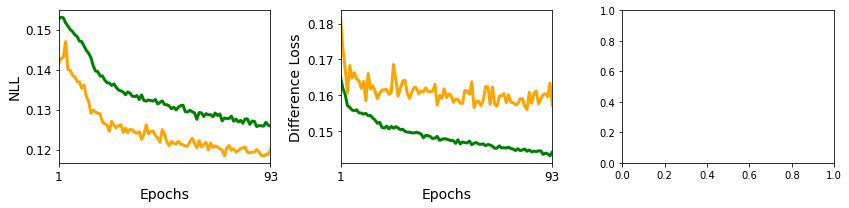

In [18]:
#Plot bootstrap training and validation losses

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

max_n_epochs_actual = 0

for bootstrap_ix in range(len(train_histories)) :
    
    train_history = train_histories[bootstrap_ix]

    n_epochs_actual = len(train_history.history['nll_loss'])
    max_n_epochs_actual = max(max_n_epochs_actual, n_epochs_actual)
    
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['difference_loss'], linewidth=3, color='green')
    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_difference_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Difference Loss", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [19]:
#Specify cell type labels

print(cell_types)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


['NT' 'CDC73' 'CPSF1' 'CPSF2' 'CPSF3' 'CPSF3L' 'CPSF4' 'CPSF6' 'CSTF1'
 'CSTF3' 'CTR9' 'FIP1L1' 'LEO1' 'NUDT21' 'PABPC1' 'PABPN1' 'PAF1' 'PAPOLA'
 'PCF11' 'RBBP6' 'RPRD1A' 'RPRD1B' 'SCAF8' 'SF3A1' 'SRSF3' 'SYMPK' 'THOC5']


In [20]:
#Evaluate boostrap ensemble on test data

n_bootstraps = 5

y_pred_scores = []
y_pred_probs = []

y_pred_scores_test = []
y_pred_probs_test = []

for bootstrap_ix in range(n_bootstraps) :
    
    #Clear keras session
    K.clear_session()
    
    print("Predicting using model " + str(bootstrap_ix) + "...")
    
    pas_model, apa_model, _ = initialize_model()
    
    #Load model(s)
    model_name = "perturb_resnet_utr3_covar_drop_all"

    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_pas_model' + '.h5')
    #pas_model = load_model(model_path)
    pas_model.load_weights(model_path)

    def _masked_softmax(y, m, axis=-1) :

        exp_y = m * (K.exp(y) + K.epsilon())

        return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

    model_path = os.path.join(save_dir, model_name + '_ensemble_' + str(bootstrap_ix) + '_apa_model' + '.h5')
    #apa_model = load_model(model_path, custom_objects={
    #    '_masked_softmax' : _masked_softmax
    #})
    apa_model.load_weights(model_path)

    #Make predictions on all data
    y_pred_score, y_pred_prob = apa_model.predict(x=[x, m, prox_mask, dist_mask, l, a], batch_size=64, verbose=True)
    
    #Make predictions on test data
    y_pred_score_test, y_pred_prob_test = apa_model.predict(x=[x_test, m_test, prox_mask_test, dist_mask_test, l_test, a_test], batch_size=64, verbose=True)

    y_pred_scores.append(y_pred_score[None, ...])
    y_pred_probs.append(y_pred_prob[None, ...])

    y_pred_scores_test.append(y_pred_score_test[None, ...])
    y_pred_probs_test.append(y_pred_prob_test[None, ...])

y_pred_score = np.mean(np.concatenate(y_pred_scores, axis=0), axis=0)
y_pred_prob = np.mean(np.concatenate(y_pred_probs, axis=0), axis=0)

y_pred_score_test = np.mean(np.concatenate(y_pred_scores_test, axis=0), axis=0)
y_pred_prob_test = np.mean(np.concatenate(y_pred_probs_test, axis=0), axis=0)


Predicting using model 0...
500/500 [==============================] - 1s 2ms/step
Predicting using model 1...
500/500 [==============================] - 0s 994us/step
Predicting using model 2...
500/500 [==============================] - 0s 999us/step
Predicting using model 3...
500/500 [==============================] - 0s 987us/step
Predicting using model 4...
500/500 [==============================] - 1s 1ms/step


NT
PAS 1:
- P-value = 0.0
- n = 5146


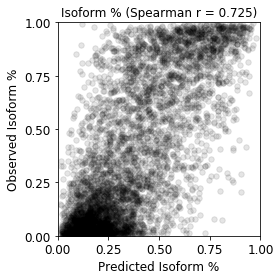

In [21]:
#Predict non-targeting condition

cell_type_1 = cell_types[0]

count_filter = 0.
pas_ix = 1

print(cell_type_1)
print("PAS " + str(pas_ix) + ":")

cell_type_1_ix = cell_type_dict[cell_type_1]

c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)

y_kept = y[(c_total_1 >= count_filter), ...]
y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter), ...]
y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter), ...]

s_kept = s[(c_total_1 >= count_filter), ...]
m_kept = m[(c_total_1 >= count_filter), ...]

y_1 = y_kept[:, cell_type_1_ix, :]

y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]

m_flat = m_kept[:, pas_ix]

y_1_flat = y_1[:, pas_ix]

y_pred_1_flat = y_pred_1[:, pas_ix]

if np.sign(pas_ix) == -1 :
    m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

y_1_flat = y_1_flat[m_flat >= 1.]

y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]

r_val, p_val = spearmanr(y_1_flat, y_pred_1_flat)

print("- P-value = " + str(p_val))
print("- n = " + str(y_1_flat.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_1_flat, y_1_flat, s=30, c='black', alpha=0.1)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel("Predicted Isoform %", fontsize=12)
plt.ylabel("Observed Isoform %", fontsize=12)

plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

#plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_reconstruction.eps')
#plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_reconstruction.png', dpi=300)

plt.show()


PAS 0:
CDC73
- P-value = 4.2225931458513304e-30
- n = 5146


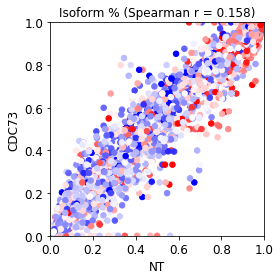

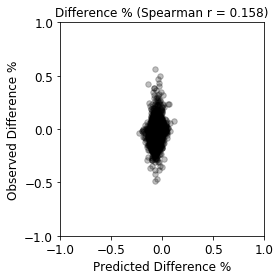

CPSF1
- P-value = 4.549103158344455e-125
- n = 5145


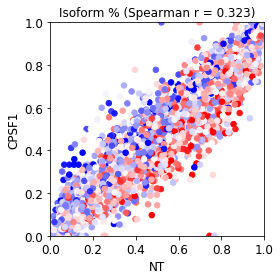

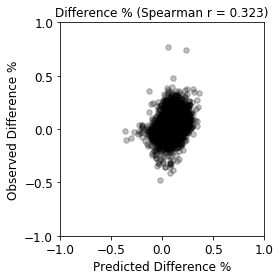

CPSF2
- P-value = 8.061718062288516e-97
- n = 5144


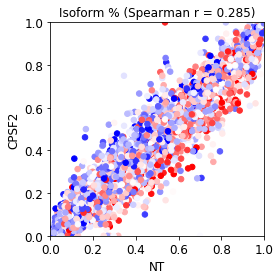

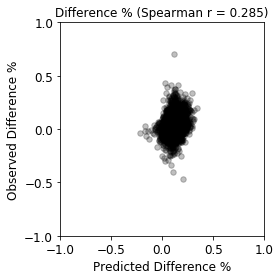

CPSF3
- P-value = 1.224445175822814e-100
- n = 5145


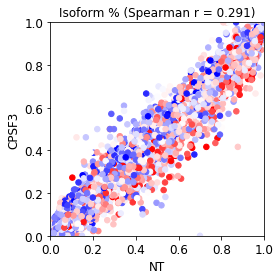

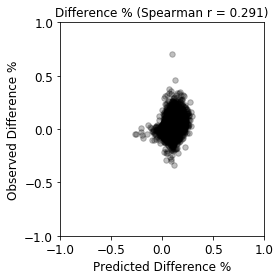

CPSF3L
- P-value = 3.6718568505825417e-45
- n = 5144


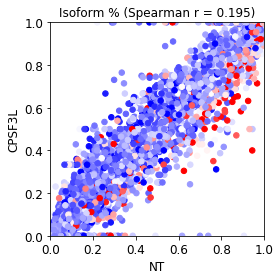

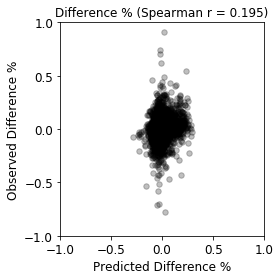

CPSF4
- P-value = 1.440438689543117e-138
- n = 5142


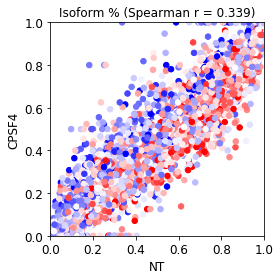

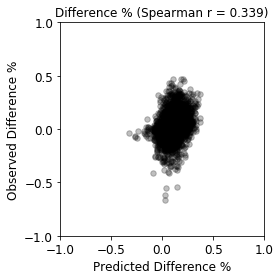

CPSF6
- P-value = 0.0
- n = 5146


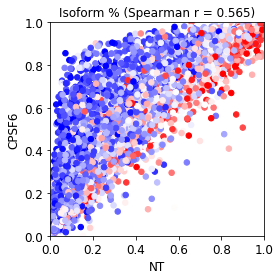

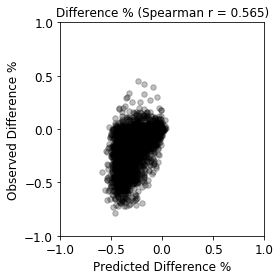

CSTF1
- P-value = 2.630751549053493e-93
- n = 5145


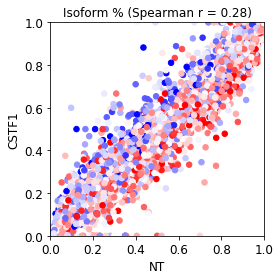

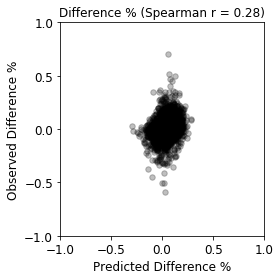

CSTF3
- P-value = 6.251484458854216e-147
- n = 5145


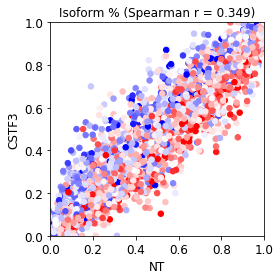

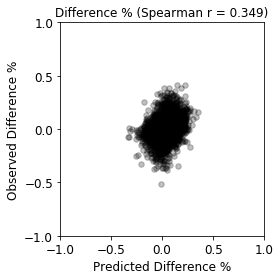

CTR9
- P-value = 4.288056505317871e-30
- n = 5145


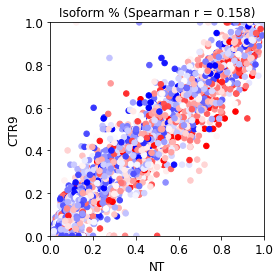

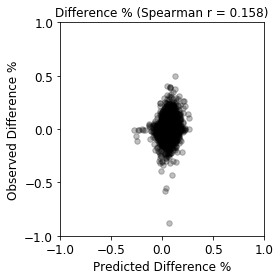

FIP1L1
- P-value = 4.741688244006408e-140
- n = 5146


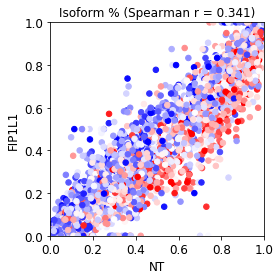

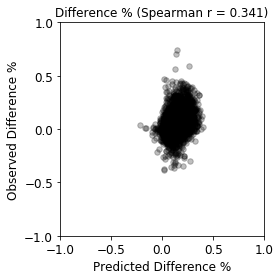

LEO1
- P-value = 1.360983797174973e-34
- n = 5146


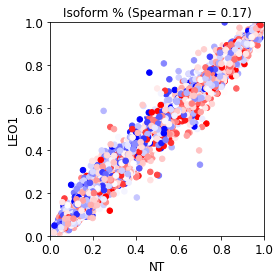

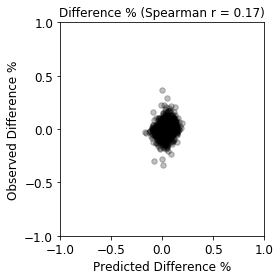

NUDT21
- P-value = 0.0
- n = 5146


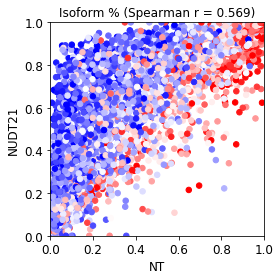

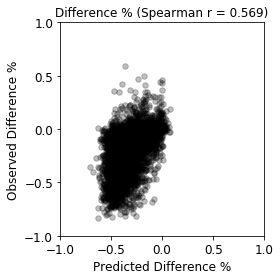

PABPC1
- P-value = 6.628793663182734e-13
- n = 5144


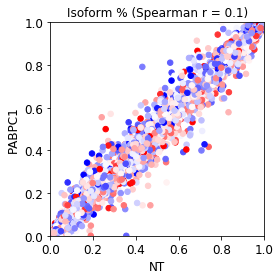

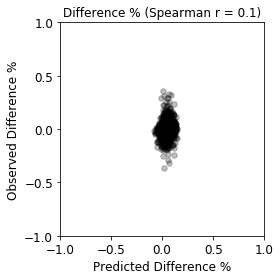

PABPN1
- P-value = 7.409934937902275e-33
- n = 5146


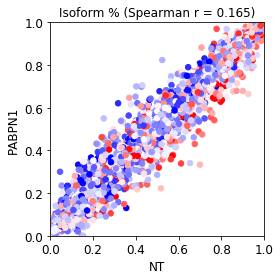

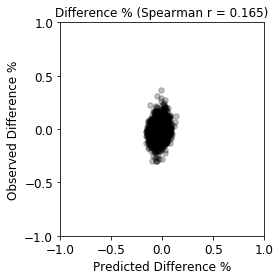

PAF1
- P-value = 2.376511915895671e-23
- n = 5145


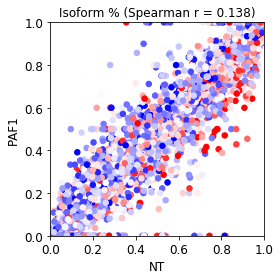

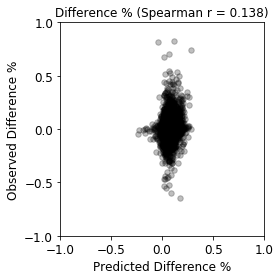

PAPOLA
- P-value = 2.888336002057996e-49
- n = 5146


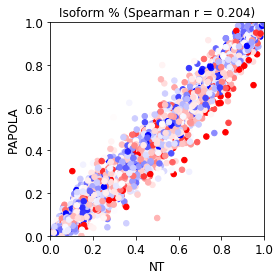

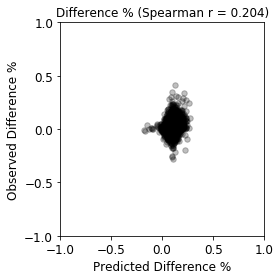

PCF11
- P-value = 1.6970949938559048e-94
- n = 5144


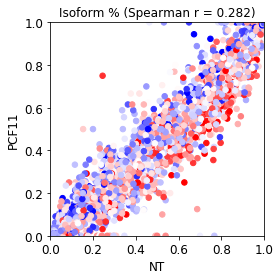

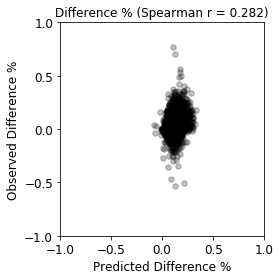

RBBP6
- P-value = 2.570802316689841e-72
- n = 5145


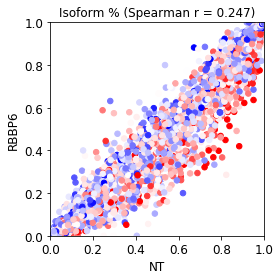

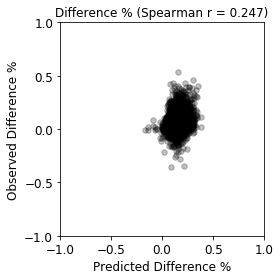

RPRD1A
- P-value = 0.00017444545255790417
- n = 5144


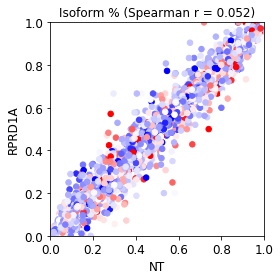

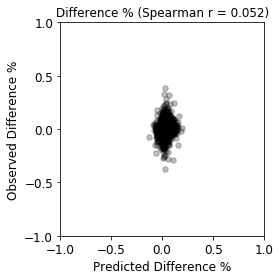

RPRD1B
- P-value = 1.4079384148113473e-15
- n = 5144


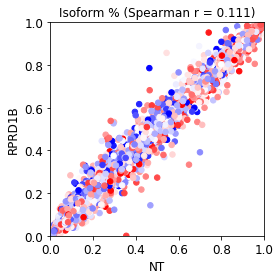

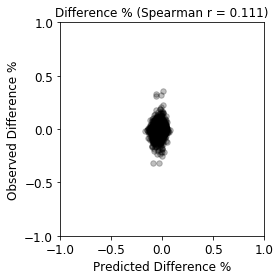

SCAF8
- P-value = 1.363066505066802e-06
- n = 5145


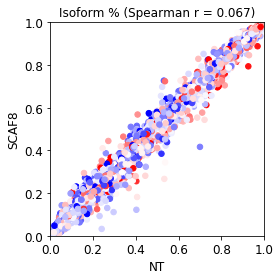

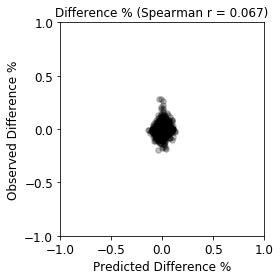

SF3A1
- P-value = 1.6797908485619218e-20
- n = 5144


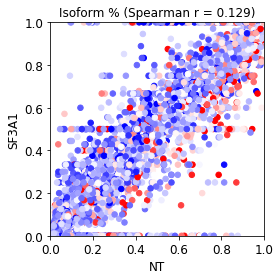

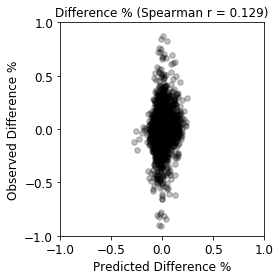

SRSF3
- P-value = 2.593542815756439e-65
- n = 5145


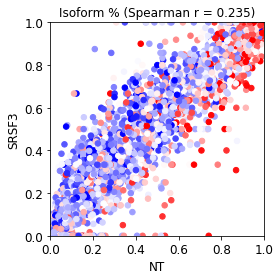

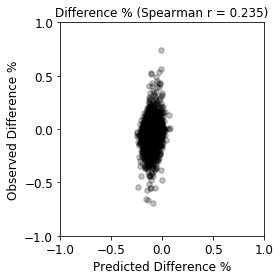

SYMPK
- P-value = 6.131740340549309e-81
- n = 5145


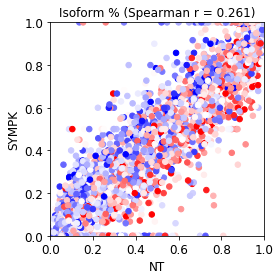

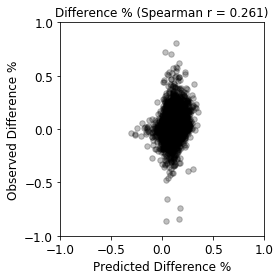

THOC5
- P-value = 2.1629566260667785e-193
- n = 5146


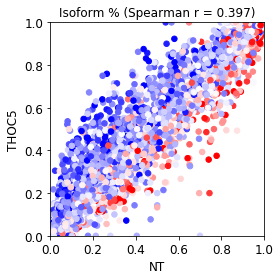

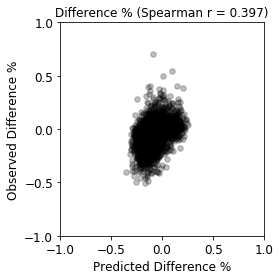

In [22]:
#Differential usage analysis

cell_type_1 = cell_types[0]

count_filter = 0.
min_y_diff = 0.0
pas_ix = 0

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types[1:].tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

    y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]

    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) > min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) > min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) > min_y_diff]
    y_diff = y_diff[np.abs(y_diff) > min_y_diff]

    r_val, p_val = spearmanr(y_diff, y_pred_diff)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_diff.shape[0]))

    f = plt.figure(figsize=(4, 4))

    vmin = np.quantile(y_pred_diff, q=0.02)
    vmax = np.quantile(y_pred_diff, q=0.98)

    plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

    plt.xlabel(cell_type_1, fontsize=12)
    plt.ylabel(cell_type_2, fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'color.eps')
    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'color.png', dpi=300)

    plt.show()

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
    plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

    plt.xlabel("Predicted Difference %", fontsize=12)
    plt.ylabel("Observed Difference %", fontsize=12)

    plt.title("Difference % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter.eps')
    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter.png', dpi=300)

    plt.show()


NT
PAS -1:
- P-value = 5.301288001814554e-77
- n = 500


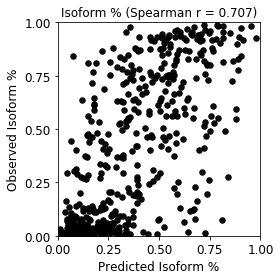

In [23]:
#Predict non-targeting condition (test)

cell_type_1 = cell_types[0]

count_filter = 0.
pas_ix = -1

print(cell_type_1)
print("PAS " + str(pas_ix) + ":")

cell_type_1_ix = cell_type_dict[cell_type_1]

c_total_1 = np.sum(c_test[:, cell_type_1_ix, :], axis=-1)

y_kept = y_test[(c_total_1 >= count_filter), ...]
y_pred_score_kept = y_pred_score_test[(c_total_1 >= count_filter), ...]
y_pred_prob_kept = y_pred_prob_test[(c_total_1 >= count_filter), ...]

s_kept = s_test[(c_total_1 >= count_filter), ...]
m_kept = m_test[(c_total_1 >= count_filter), ...]

y_1 = y_kept[:, cell_type_1_ix, :]

y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]

m_flat = m_kept[:, pas_ix]

y_1_flat = y_1[:, pas_ix]

y_pred_1_flat = y_pred_1[:, pas_ix]

if np.sign(pas_ix) == -1 :
    m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

y_1_flat = y_1_flat[m_flat >= 1.]

y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]

r_val, p_val = spearmanr(y_1_flat, y_pred_1_flat)

print("- P-value = " + str(p_val))
print("- n = " + str(y_1_flat.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_1_flat, y_1_flat, s=30, c='black', alpha=0.95)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel("Predicted Isoform %", fontsize=12)
plt.ylabel("Observed Isoform %", fontsize=12)

plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

#plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_reconstruction_test.eps')
#plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + 'scatter_reconstruction_test.png', dpi=300)

plt.show()


PAS 0:
CDC73
- P-value = 0.2353121897162961
- n = 500


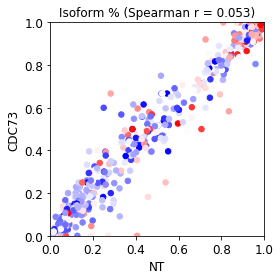

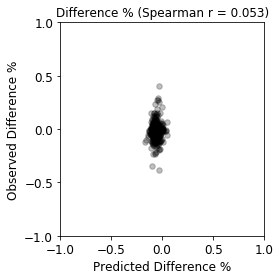

CPSF1
- P-value = 9.232101977461731e-09
- n = 500


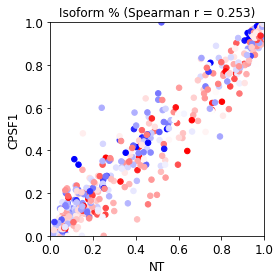

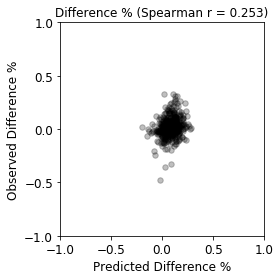

CPSF2
- P-value = 1.3717612986789415e-06
- n = 500


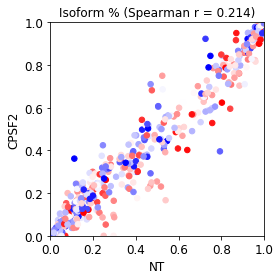

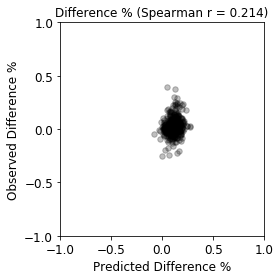

CPSF3
- P-value = 1.6390386385997835e-06
- n = 499


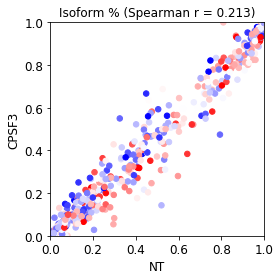

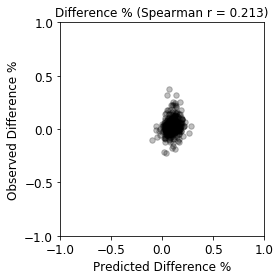

CPSF3L
- P-value = 0.00020985290984993577
- n = 500


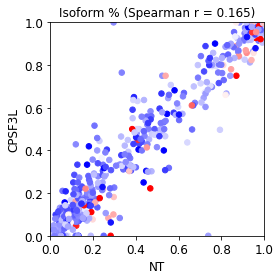

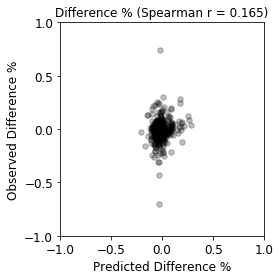

CPSF4
- P-value = 6.903438360056418e-08
- n = 498


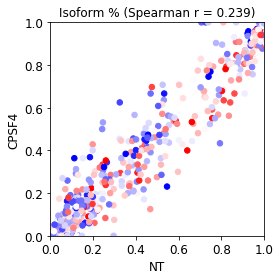

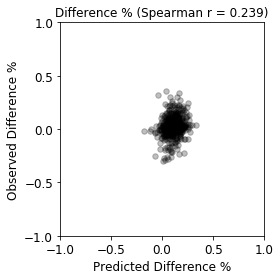

CPSF6
- P-value = 5.244033841136054e-30
- n = 500


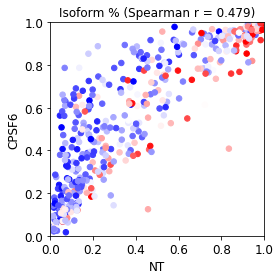

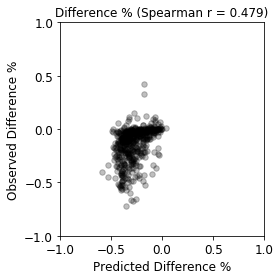

CSTF1
- P-value = 6.41968182480443e-10
- n = 500


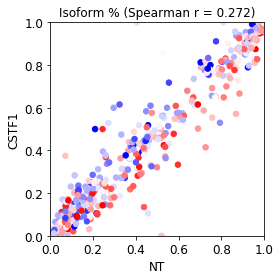

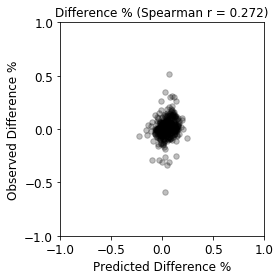

CSTF3
- P-value = 3.4056323897576688e-12
- n = 500


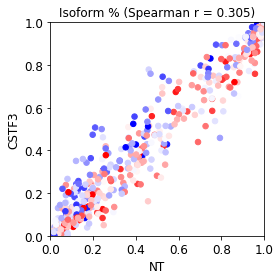

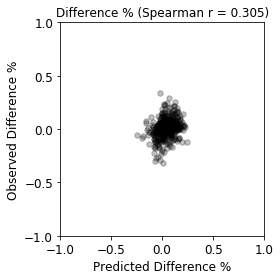

CTR9
- P-value = 0.23599611259538808
- n = 500


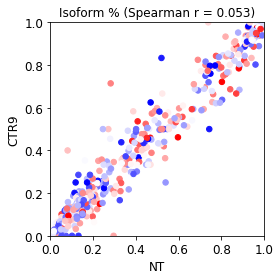

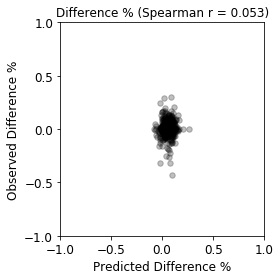

FIP1L1
- P-value = 2.1518325280502444e-10
- n = 500


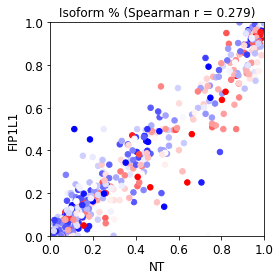

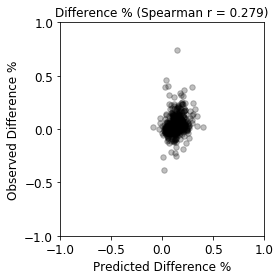

LEO1
- P-value = 0.015431360795282494
- n = 500


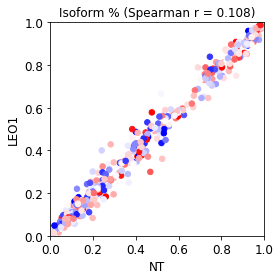

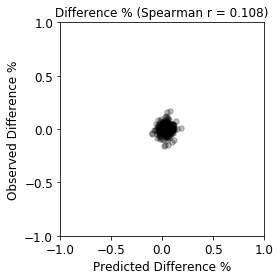

NUDT21
- P-value = 1.7175621889162894e-33
- n = 500


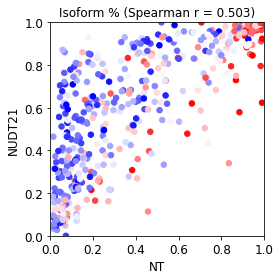

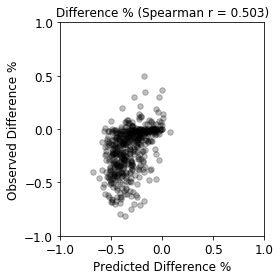

PABPC1
- P-value = 0.44339794246088327
- n = 499


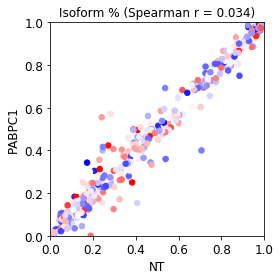

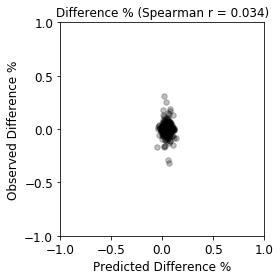

PABPN1
- P-value = 0.02603003948706536
- n = 500


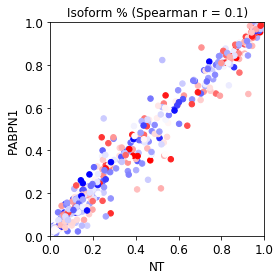

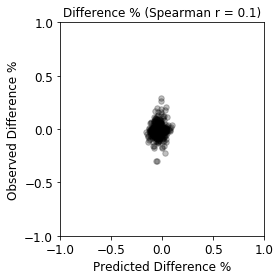

PAF1
- P-value = 0.023684142057194296
- n = 500


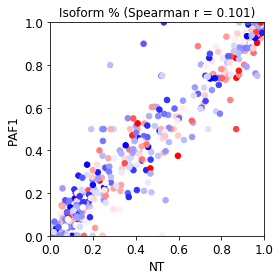

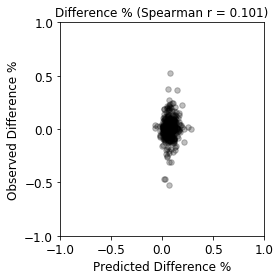

PAPOLA
- P-value = 0.046275814716495216
- n = 500


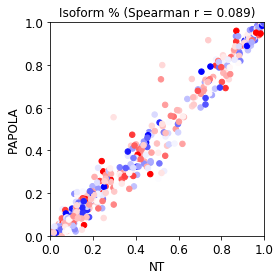

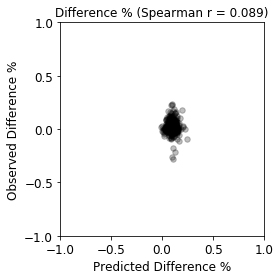

PCF11
- P-value = 1.0562135248512717e-07
- n = 500


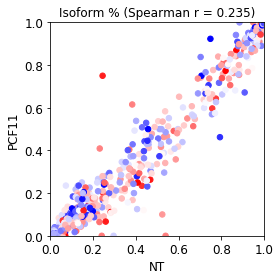

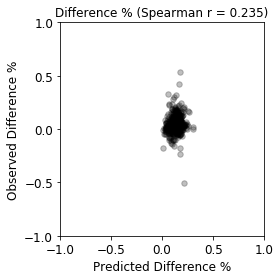

RBBP6
- P-value = 1.8876713833711742e-05
- n = 500


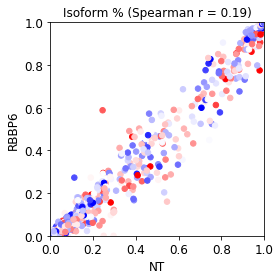

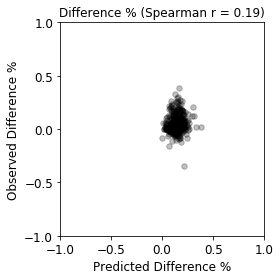

RPRD1A
- P-value = 0.1339823013242794
- n = 500


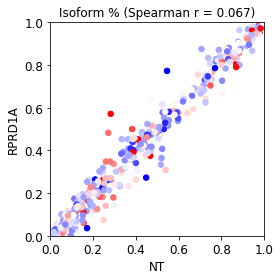

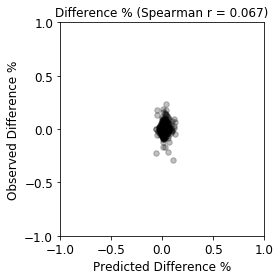

RPRD1B
- P-value = 0.05292986031632746
- n = 500


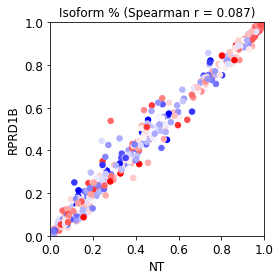

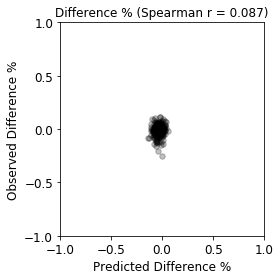

SCAF8
- P-value = 0.6563766809447912
- n = 500


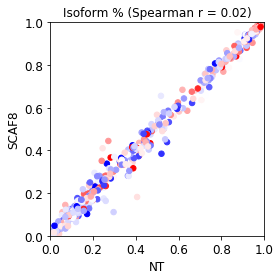

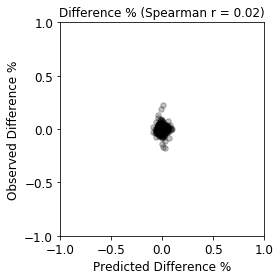

SF3A1
- P-value = 0.13847365632576933
- n = 500


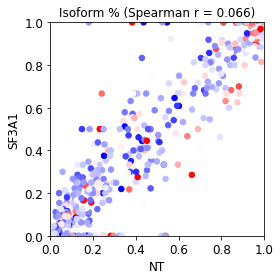

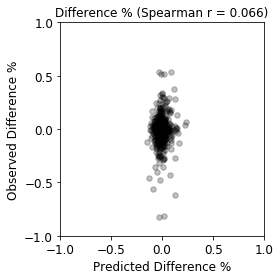

SRSF3
- P-value = 4.362441320073431e-05
- n = 500


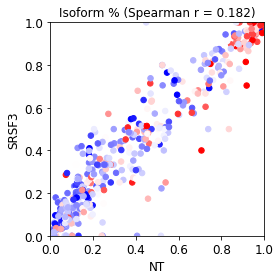

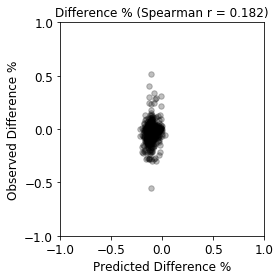

SYMPK
- P-value = 8.653466131587891e-06
- n = 500


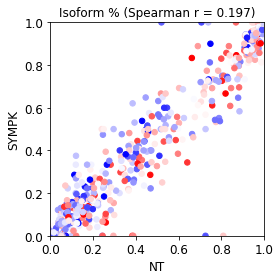

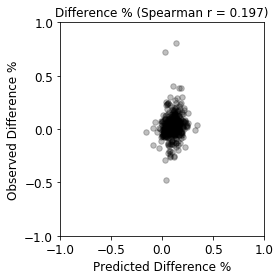

THOC5
- P-value = 1.1421206516042453e-15
- n = 500


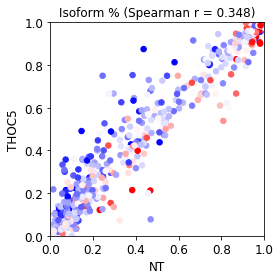

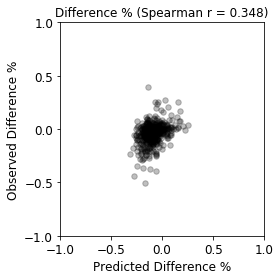

In [24]:
#Differential usage analysis (test)

cell_type_1 = cell_types[0]

count_filter = 0.
min_y_diff = 0.0
pas_ix = 0

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types[1:].tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c_test[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c_test[:, cell_type_2_ix, :], axis=-1)

    y_kept = y_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m_test[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]

    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) > min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) > min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) > min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) > min_y_diff]
    y_diff = y_diff[np.abs(y_diff) > min_y_diff]

    r_val, p_val = spearmanr(y_diff, y_pred_diff)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_diff.shape[0]))

    f = plt.figure(figsize=(4, 4))

    vmin = np.quantile(y_pred_diff, q=0.02)
    vmax = np.quantile(y_pred_diff, q=0.98)

    plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

    plt.xlabel(cell_type_1, fontsize=12)
    plt.ylabel(cell_type_2, fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + '_' + cell_type_2 + '_color_test.eps')
    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + '_' + cell_type_2 + '_color_test.png', dpi=300)

    plt.show()

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
    plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

    plt.xlabel("Predicted Difference %", fontsize=12)
    plt.ylabel("Observed Difference %", fontsize=12)

    plt.title("Difference % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + '_' + cell_type_2 + '_scatter_test.eps')
    #plt.savefig(model_name + '_ensemble_pas_' + str(pas_ix) + '_' + cell_type_2 + '_scatter_test.png', dpi=300)

    plt.show()
